In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [10]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import numpy as np
import os
os.getcwd()
os.chdir("/nfs/pic.es/user/m/mbilkis/qmon-sindy")
from numerics.utilities.misc import *
import matplotlib.pyplot as plt 
from numerics.NN.models import *
from numerics.NN.misc import * 
import torch
import numpy as np
from scipy.linalg import solve_continuous_are




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
os.system("python3.11 numerics/NN/modes/osc_exp_dec.py --itraj 1")

In [6]:
mode="osc-exp-dec"

In [18]:
os.system("python3.11 numerics/integration/external_forces/osc-exp-dec.py --itraj 1")

[[-1.  5.]
 [-5. -1.]]


0

In [164]:

class GRNN(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(GRNN, self).__init__()

        self.dt, self.simulation_params, trainable_params = inputs_cell
        kernel_params = trainable_params[1:]
        gamma, omega, n, eta, kappa, b = self.simulation_params

        self.kernel_params = torch.nn.Parameter(data = torch.tensor(kernel_params,dtype=torch.float32,
                                                              requires_grad=True))

        self.A = torch.tensor(data=[[-gamma/2, omega],[-omega,-gamma/2]], dtype=torch.float32).detach()
        self.proj_C = torch.tensor(data=[[1.,0.],[0.,0.]], dtype=torch.float32).detach()
        self.C = np.sqrt(4*eta*kappa)*self.proj_C.detach()
        self.D = (gamma*(n+0.5) + kappa)*torch.eye(2).detach()
        
        self.proj_F = torch.tensor(data=[[[0,0],[1,0]]], dtype=torch.float32).detach() # the first component of f is the HMM,that enters as a force in the second component of x


    def forward(self, dy, state, f):
        """
        input_data is dy
        hidden_state is x: (<q>, <p>, Var[x], Var[p], Cov(q,q)})
        output dy_hat
        """
        x = state[:2]
        [vx,vp,cxp] = state[2:5]
        t = state[-1]
        cov = torch.tensor(data = [[vx,cxp],[cxp,vp]], dtype=torch.float32)

        xicov = cov.matmul(self.C.T)
        dx = (self.A - xicov.matmul(self.C)).matmul(x)*self.dt + xicov.matmul(dy)

        df = torch.squeeze(self.kernel_params).matmul(f)*self.dt # +   self.dt*self.kernel_params[1]*f**2

        fnew = f + df
        #global v1,v2
        #v1 = fnew
        #v2 = self.proj_F
        dx += torch.squeeze(self.proj_F).matmul(fnew)*self.dt
        dcov = self.dt*(cov.matmul(self.A.T) + (self.A).matmul(cov) + self.D - (xicov.matmul(xicov.T)))
        ncov = cov+dcov
        nstate = torch.concatenate([(x + dx), torch.tensor([ncov[0,0],ncov[1,1],ncov[1,0]]), torch.tensor([t+self.dt])])
        dy_hat = self.C.matmul(x)*self.dt
        return nstate, dy_hat, fnew

class RecurrentNetwork(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(RecurrentNetwork, self).__init__()
        self.RCell = GRNN(inputs_cell=inputs_cell)
        self.dt, self.simulation_params, trainable_params = inputs_cell

        self.initial_state = torch.nn.Parameter(torch.tensor(trainable_params[0]))

    def forward(self, dys):
        dys_hat = []

        ### Find stationary value of covariance for the parameter RCell currently has
        gamma, omega, n, eta, kappa, b = self.simulation_params
        A = np.array([[-gamma/2, omega],[-omega, -gamma/2]])
        proj_C = np.array([[1.,0.],[0.,0.]])
        C = np.sqrt(4*eta*kappa)*proj_C
        D = np.diag([gamma*(n+0.5) + kappa]*2)
        G = np.zeros((2,2))
        Cov = solve_continuous_are((A-G.dot(C)).T, C.T, D- (G.T).dot(G), np.eye(2)) #### A.T because the way it's implemented!
        t0=0.
        xs_hat = [torch.tensor([0., 0., Cov[0,0], Cov[1,1],Cov[1,0], t0], dtype=torch.float32)]

        fs_hat = [self.initial_state]

        x_hat = xs_hat[0]
        f_hat = fs_hat[0]
        for dy_t in dys:
            x_hat, dy_hat, f_hat = self.RCell(dy_t, x_hat, f_hat)
            dys_hat += [dy_hat]
            xs_hat += [x_hat]
            fs_hat+=[f_hat]
        return torch.stack(xs_hat), torch.stack(dys_hat), torch.stack(fs_hat)


In [151]:
itraj = 1
x = load_data(itraj=itraj, what="hidden_state.npy",mode=mode)
dy = load_data(itraj=itraj,what="dys.npy",mode=mode)
f = load_data(itraj=itraj, what="external_signal.npy",mode=mode)
####
params, exp_path = give_params(mode=mode)
gamma, omega, n, eta, kappa, params_force, [periods, ppp] = params
period = (2*np.pi/omega)
total_time = period*periods
dt = period/ppp
times = np.arange(0,total_time+dt,dt)
###
gf = .5
wf=5.
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], [[200.,0], [[-gf,wf],[-wf,-gf]]  ]]



In [152]:
torch.manual_seed(0)

dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)

optimizer = torch.optim.Adam(list(rrn.parameters()), lr=1e-2)

dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))
xs_hat, dys_hat, fs_hats = rrn(dys)

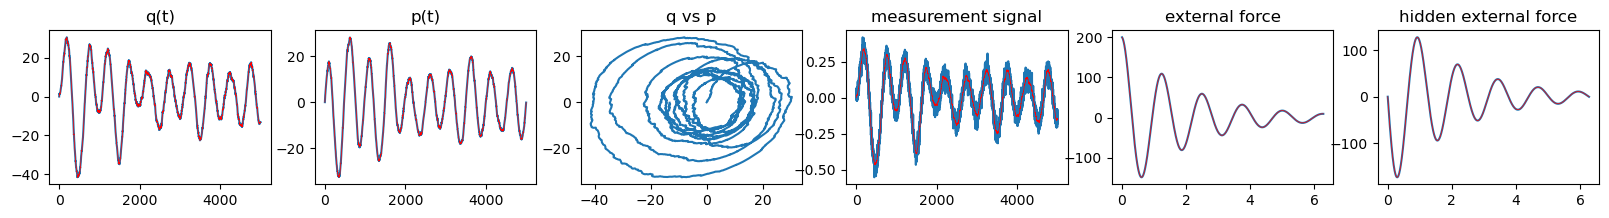

In [160]:
ll_pred=.5
plt.figure(figsize=(20,2))
ax=plt.subplot(161)
ax.plot(x[:,0])
ax.plot(xs_hat.detach().numpy()[:,0], linewidth=ll_pred, color="red")

ax.set_title("q(t)")
ax=plt.subplot(162)
ax.plot(x[:,1])
ax.plot(xs_hat.detach().numpy()[:,1], linewidth=ll_pred, color="red")
ax.set_title("p(t)")

ax=plt.subplot(163)
ax.plot(x[:,0],x[:,1])
ax.set_title("q vs p")

ax=plt.subplot(164)
ax.plot(dy[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], linewidth=ll_pred, color="red")
ax.set_title("measurement signal")
ax=plt.subplot(165)
ax.plot(times,f[:,0])
ax.plot(times, fs_hats[:,0].detach().numpy()[:-1] , linewidth=ll_pred, color="red")
ax.set_title("external force")

ax=plt.subplot(166)
ax.set_title("hidden external force")
ax.plot(times,f[:,1])
ax.plot(times, fs_hats[:,1].detach().numpy()[:-1], linewidth=ll_pred, color="red")

In [170]:
from scipy.linalg import solve_continuous_are
from numerics.NN.losses import *
from numerics.NN.misc import *
import copy

In [171]:
torch.manual_seed(0)

dev = torch.device("cpu")

gf = .1
wf=.7
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], [[200.,0], [[-gf,wf],[-wf,-gf]]  ]]

rrn = RecurrentNetwork(inputs_cell)

optimizer = torch.optim.Adam(list(rrn.parameters()), lr=1e-2)

dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))

xs_hat, dys_hat, fs_hats = rrn(dys)
loss = log_lik(dys, dys_hat)
history = {}
history["losses"] = [ [loss.item(),err_f(f[:,0],fs_hats[:,0])]  ]
history["params"] = [[k.detach().data for k in list(rrn.parameters())]]
history["gradients"] = []

In [167]:
printing=True

In [172]:

if printing==True:

    print(loss.item())
    print(err_f(f[:,0],fs_hats[:,0]))
    print(history["params"][-1])
    print("\n")

for ind in range(3000):
    xs_hat, dys_hat, fs_hats = rrn(dys)
    loss = log_lik(dys, dys_hat, dt=dt)
    loss.backward()
    signal_distance = err_f(f[:,0],fs_hats[:,0])
    optimizer.step()


    history["losses"].append([loss.item(),signal_distance] )
    history["params"].append([k.detach().data for k in copy.deepcopy(list(rrn.parameters()))])
    history["gradients"].append(copy.deepcopy([k.grad.numpy() for k in list(rrn.parameters())]))

    if printing==True:

        print("**** iteration {} ****".format(ind))
        print(loss.item())
        print(signal_distance)
        print(history["params"][-1])
        print("\n")
    optimizer.zero_grad()
    save_history(history, itraj=itraj, exp_path=exp_path,what="exp_dec_2_params")

    if np.abs(loss.item()) < 1+1e-7:
        break


2.1930763721466064
2.577865106642022
[tensor([200.,   0.]), tensor([[[-0.1000,  0.7000],
         [-0.7000, -0.1000]]])]


**** iteration 0 ****
1.7451947927474976
2.577865106642022
[tensor([ 1.9999e+02, -9.9999e-03]), tensor([[[-0.1100,  0.7100],
         [-0.7100, -0.1100]]])]


**** iteration 1 ****
1.712845802307129
2.495401019358534
[tensor([ 1.9998e+02, -1.9996e-02]), tensor([[[-0.1200,  0.7200],
         [-0.7200, -0.1200]]])]


**** iteration 2 ****
1.6831997632980347
2.4167971316338113
[tensor([ 1.9997e+02, -2.9984e-02]), tensor([[[-0.1299,  0.7300],
         [-0.7300, -0.1299]]])]


**** iteration 3 ****
1.6560850143432617
2.341938072776935
[tensor([ 1.9996e+02, -3.9959e-02]), tensor([[[-0.1397,  0.7399],
         [-0.7399, -0.1397]]])]


**** iteration 4 ****
1.6313164234161377
2.270480027055123
[tensor([ 1.9995e+02, -4.9916e-02]), tensor([[[-0.1495,  0.7498],
         [-0.7498, -0.1494]]])]


**** iteration 5 ****
1.6087079048156738
2.202346579899586
[tensor([ 1.9994e+02, -


KeyboardInterrupt



In [173]:
ll = np.stack(history["losses"])

In [198]:
torch.manual_seed(0)
gf = .1
wf=.7
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], [[200.,0], [[-gf,wf],[-wf,-gf]]  ]]
irrn = RecurrentNetwork(inputs_cell)
dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))
ixs_hat, idys_hat, ifs_hats = irrn(dys)


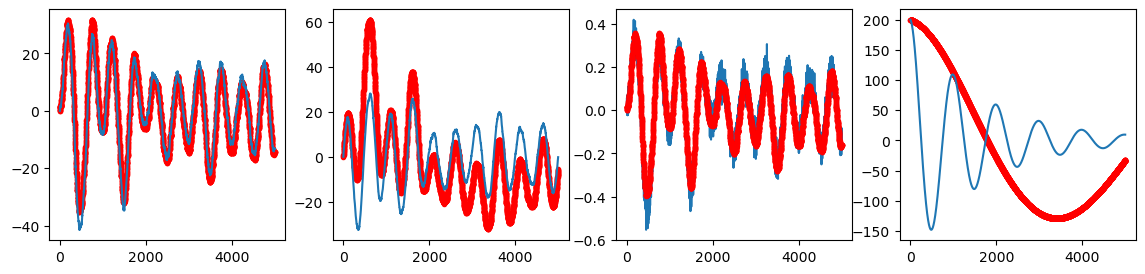

In [199]:
plt.figure(figsize=(25,3))
ax=plt.subplot(171)
ax.plot(ixs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(172)
ax.plot(ixs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(173)
ax.plot(dys[:,0])
ax.plot(idys_hat.detach().numpy()[:,0], color="red",marker='.')

ax=plt.subplot(174)
ax.plot(ifs_hats.detach().numpy()[:,0], color="red",marker='.')
ax.plot(f[:,0])


Text(0, 0.5, '$\\frac{\\sum_k |f_k - \\hat{f}_k|}{\\sum_k |f_k|}$')

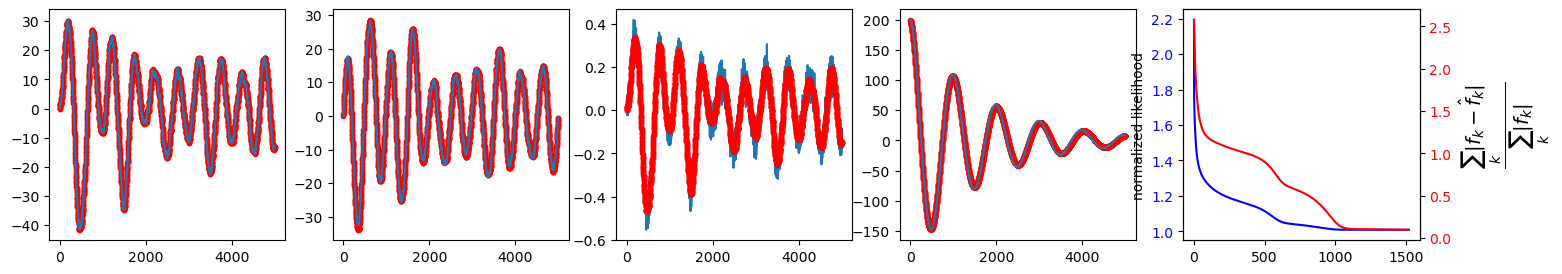

In [175]:
plt.figure(figsize=(25,3))
ax=plt.subplot(171)
ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(172)
ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(173)
ax.plot(dys[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

ax=plt.subplot(174)
ax.plot(fs_hats.detach().numpy()[:,0], color="red",marker='.')
ax.plot(f[:,0])

ax=plt.subplot(175)
ax.plot(ll[:,0], color="blue")
ax.set_ylabel("normalized likelihood")
ax.tick_params(axis='y', labelcolor="blue")
ax = ax.twinx()
ax.plot(ll[:,1], color="red")
ax.tick_params(axis='y', labelcolor="red")
ax.set_ylabel(r'$\frac{\sum_k |f_k - \hat{f}_k|}{\sum_k |f_k|}$',size=20)

In [184]:
Ahist = np.squeeze(np.stack([history["params"][k][1] for k in range(len(history["params"]))]))
f0 = np.squeeze(np.stack([history["params"][k][0] for k in range(len(history["params"]))]))

In [188]:
true_gamma = b[1][0]
true_omega = b[1][1]
true_f0 = b[0][0]
true_f0_dot = b[0][1]

In [195]:
Ahist[-1]

array([[-0.90564907,  4.9382286 ],
       [-4.9314656 , -0.12887985]], dtype=float32)

In [206]:
Atrue = np.array([[true_gamma, true_omega],[-true_omega, true_gamma]] )

In [202]:
Atrue

[[-0.5, 5.0], [-5.0, -0.5]]

Text(0.5, 0, 'epochs')

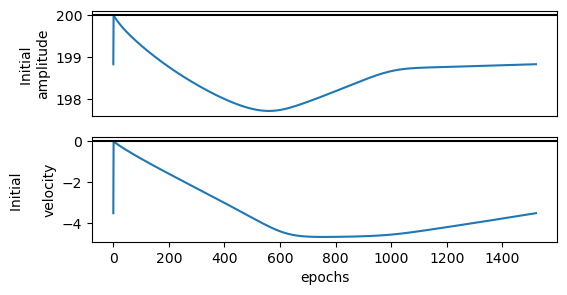

In [220]:
fig=plt.figure(figsize=(6,3))
ax=plt.subplot(211)
ax.plot(f0[:,0])
ax.set_ylabel("Initial \namplitude")
ax.set_xticks([])
ax.axhline(true_f0,color="black")
ax=plt.subplot(212)
ax.plot(f0[:,1])
ax.set_ylabel("Initial \n \nvelocity")
ax.axhline(true_f0_dot,color="black")
ax.set_xlabel("epochs")

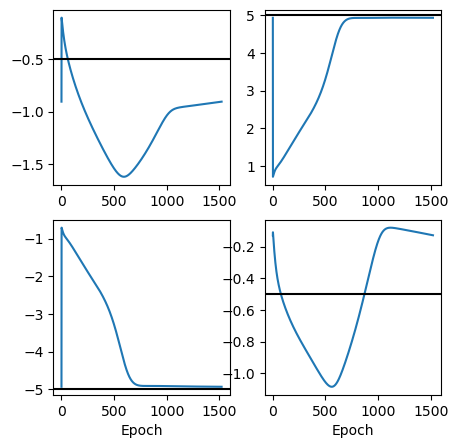

In [214]:
plt.figure(figsize=(5,5))
plt.tight_layout()
posis=[221,222,223,224]
k=0
for i in range(2):
    for j in range(2):
        ax=plt.subplot(posis[k])
        ax.plot(Ahist[:,i,j], label="pred")
        ax.axhline(Atrue[i,j],color="black")
        if k in [0,1]:
            ax.set_xlabel("")
        else:
            ax.set_xlabel("Epoch")            
        k+=1


In [182]:
np.squeeze(Ahist).shape

(1522, 2, 2)

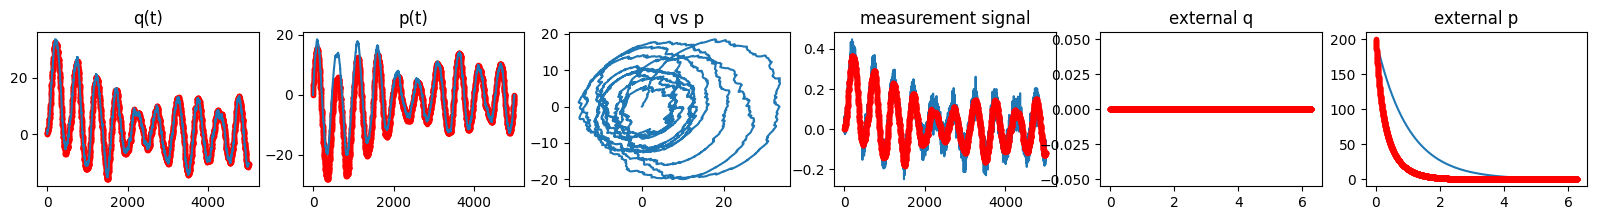


# Training

In [14]:
def log_lik(dys, dys_hat):
    return torch.sum((dys-dys_hat)**2)/(dt*len(dys))

def err_f(f,fhat):
    return np.sum(np.abs(f - fhat[:-1,:].detach().numpy() ))/np.sum(np.abs(f))

In [21]:
ll = np.stack(history["losses"])

Text(0, 0.5, '$\\frac{\\sum_k |f_k - \\hat{f}_k|}{\\sum_k |f_k|}$')

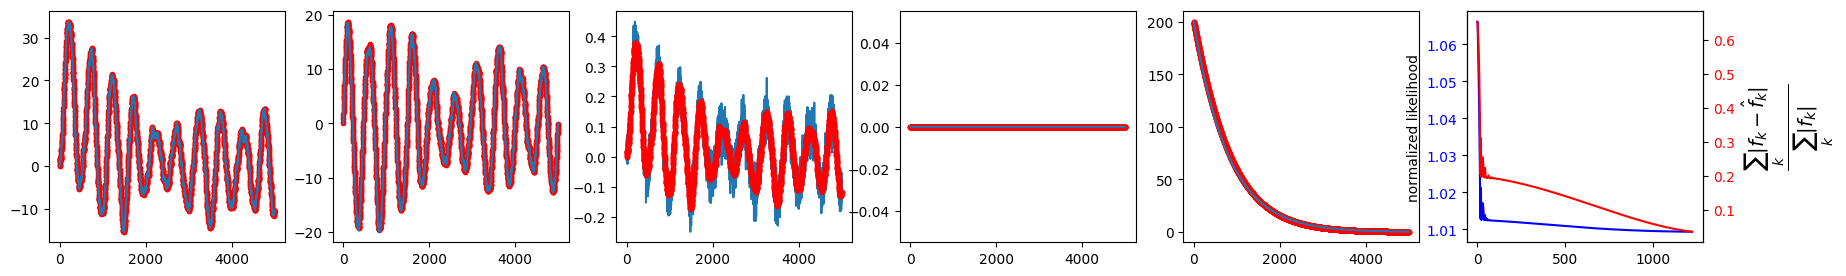

In [37]:
history["params"][4]

[array(1.6777, dtype=float32),
 array(-0.00103082, dtype=float32),
 array([0.64584786, 0.9788142 ], dtype=float32)]

In [38]:
[history["params"][k][0] for k in range(3,len(history["params"])-1)]

[array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1

In [22]:
import pickle
itraj = 1
path = get_def_path()+ exp_path + "{}itraj/T_{}_dt_{}/".format(itraj, total_time, dt)+"/EXPONENTIALLY_DEC/DERIVATIVE_only_gamma/"
os.makedirs(path,exist_ok=True)

with open(path+"history.pickle", "wb") as output_file:
   pickle.dump(history, output_file)

In [35]:
path = get_def_path()+ exp_path + "{}itraj/T_{}_dt_{}/".format(itraj, total_time, dt)+"/EXPONENTIALLY_DEC/PROFILE_only_gamma/"
with open(path+"history.pickle", "rb") as output_file:
   aa = pickle.load(output_file)
hsitory_prof = aa

In [25]:
path = get_def_path()+ exp_path + "{}itraj/T_{}_dt_{}/".format(itraj, total_time, dt)+"/EXPONENTIALLY_DEC/DERIVATIVE_only_gamma/"

os.makedirs(path,exist_ok=True)

with open(path+"history.pickle", "wb") as output_file:
   pickle.dump(history, output_file)


with open(path+"history.pickle", "rb") as output_file:
   aa = pickle.load(output_file)

history_der = aa

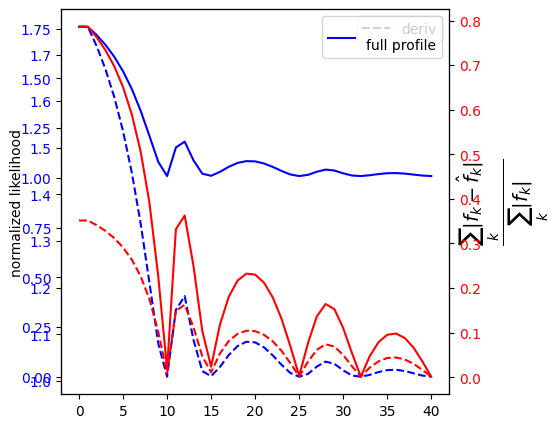

In [41]:
plt.figure(figsize=(5,5))
ax=plt.subplot()
ll = np.stack(history_der["losses"])
ax.plot(ll[:,0], '--',color="blue",label="deriv")
ax.legend()
ax.set_ylabel("normalized likelihood")
ax.tick_params(axis='y', labelcolor="blue")
ax = ax.twinx()
ax.plot(ll[:,1], '--', color="red")
ax.tick_params(axis='y', labelcolor="red")
ax.set_ylabel(r'$\frac{\sum_k |f_k - \hat{f}_k|}{\sum_k |f_k|}$',size=20)

ll = np.stack(hsitory_prof["losses"])
ax.plot(ll[:,0], color="blue",  label="\nfull profile")
ax.tick_params(axis='y', labelcolor="blue")

ax.legend()
ax = ax.twinx()
ax.plot(ll[:,1], color="red")
ax.tick_params(axis='y', labelcolor="red")


### Let's check now the amplitude!

In [125]:
xs_hat.shape

torch.Size([5002, 6])

In [131]:
[history["params"][k] for k in range(3,len(params))]

[[array(0.7952589, dtype=float32),
  array(1.7952825, dtype=float32),
  array([0.7952589, 0.7942535], dtype=float32)],
 [array(0.7952589, dtype=float32),
  array(1.7952825, dtype=float32),
  array([0.7952589, 0.7942535], dtype=float32)],
 [array(0.7952589, dtype=float32),
  array(1.7952825, dtype=float32),
  array([0.7952589, 0.7942535], dtype=float32)],
 [array(0.7952589, dtype=float32),
  array(1.7952825, dtype=float32),
  array([0.7952589, 0.7942535], dtype=float32)]]

In [122]:
ll={}
for j in range(len(history["params"][0])):
    l[j] = [history["params"][k][j] for k in len(history["params"])]

TypeError: len() of unsized object

In [118]:
history["params"]

[array(nan, dtype=float32),
 array(nan, dtype=float32),
 array([nan, nan], dtype=float32),
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float3